In [14]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline import FunctionTransformer

plt.style.use("seaborn-v0_8")
random_state = 42

---
# Support Vector Machine [(SVC doc)](https://scikit-learn.org/stable/modules/svm.html#svc)

- A support vector machine constructs a hyper-plane (or set of hyper-planes) in a high or infinite dimensional space, which can be used for classification, regression or other tasks. <br>
- Intuitively, a good separation is achieved by the hyper-plane that has *the largest distance to the nearest training data points of any class* (so-called **functional margin**), since in general the larger the margin the lower the generalization error of the classifier.<br>
The figure below shows the decision function for a linearly separable problem, with three samples on the margin boundaries, called ***support vectors***:

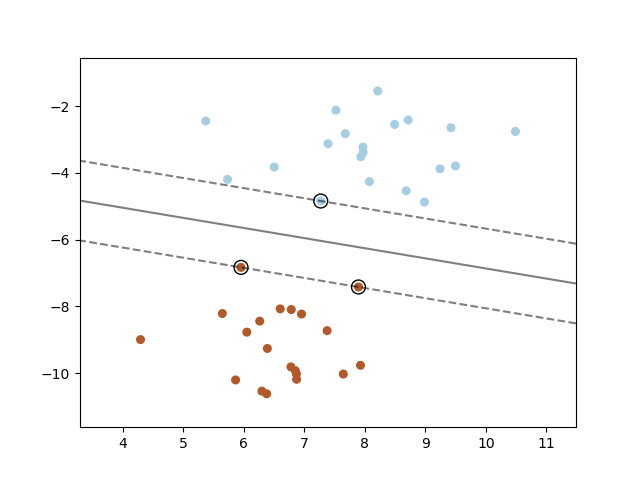
<br>
- Finding the support vectors and the maximum margin hyperplane belongs to the well known class of constrained quadratic optimization problems
- In general, when the problem isn’t linearly separable, the support vectors are the samples within the margin boundaries. The nonlinearity of boundaries can be overcome with a non–linear mapping: the data are mapped into a new space, usually called feature space, such that a linear boundary in the feature space can correspond to a non–linear boundary in the original space. The feature space can have a number of dimensions higher than the original one. Defining the mapping on the basis of a particular family of functions, called kernel functions, the mapping does not need to be explicitly computed, and the computation is done in the input space. This avoids an increase in the complexity.

- Practical details:
    - It is highly recommended to *scale the data* (both train and test) (min-max alike, or std-scaler alike)
    - *C*, the penalty parameter of the error term, controls the amount of overfitting
    - If the data is *unbalanced* (e.g. many positive and few negative), set class_weight='balanced' and/or try different penalty parameters *C*.
    - SVM does not suffer from the curse of dimensionality: does not use any notion of distance
    - SVMs do not directly provide probability estimates. Nevertheless, SVM can produce a confidence score related to the distance of an example from the separation hyperplane.

In [15]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, [0, 3]]
encoder = LabelEncoder()
df_Y = encoder.fit_transform(df["Class"])

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_Y, test_size=0.33, random_state=random_state
)

ParamGrid length: 432


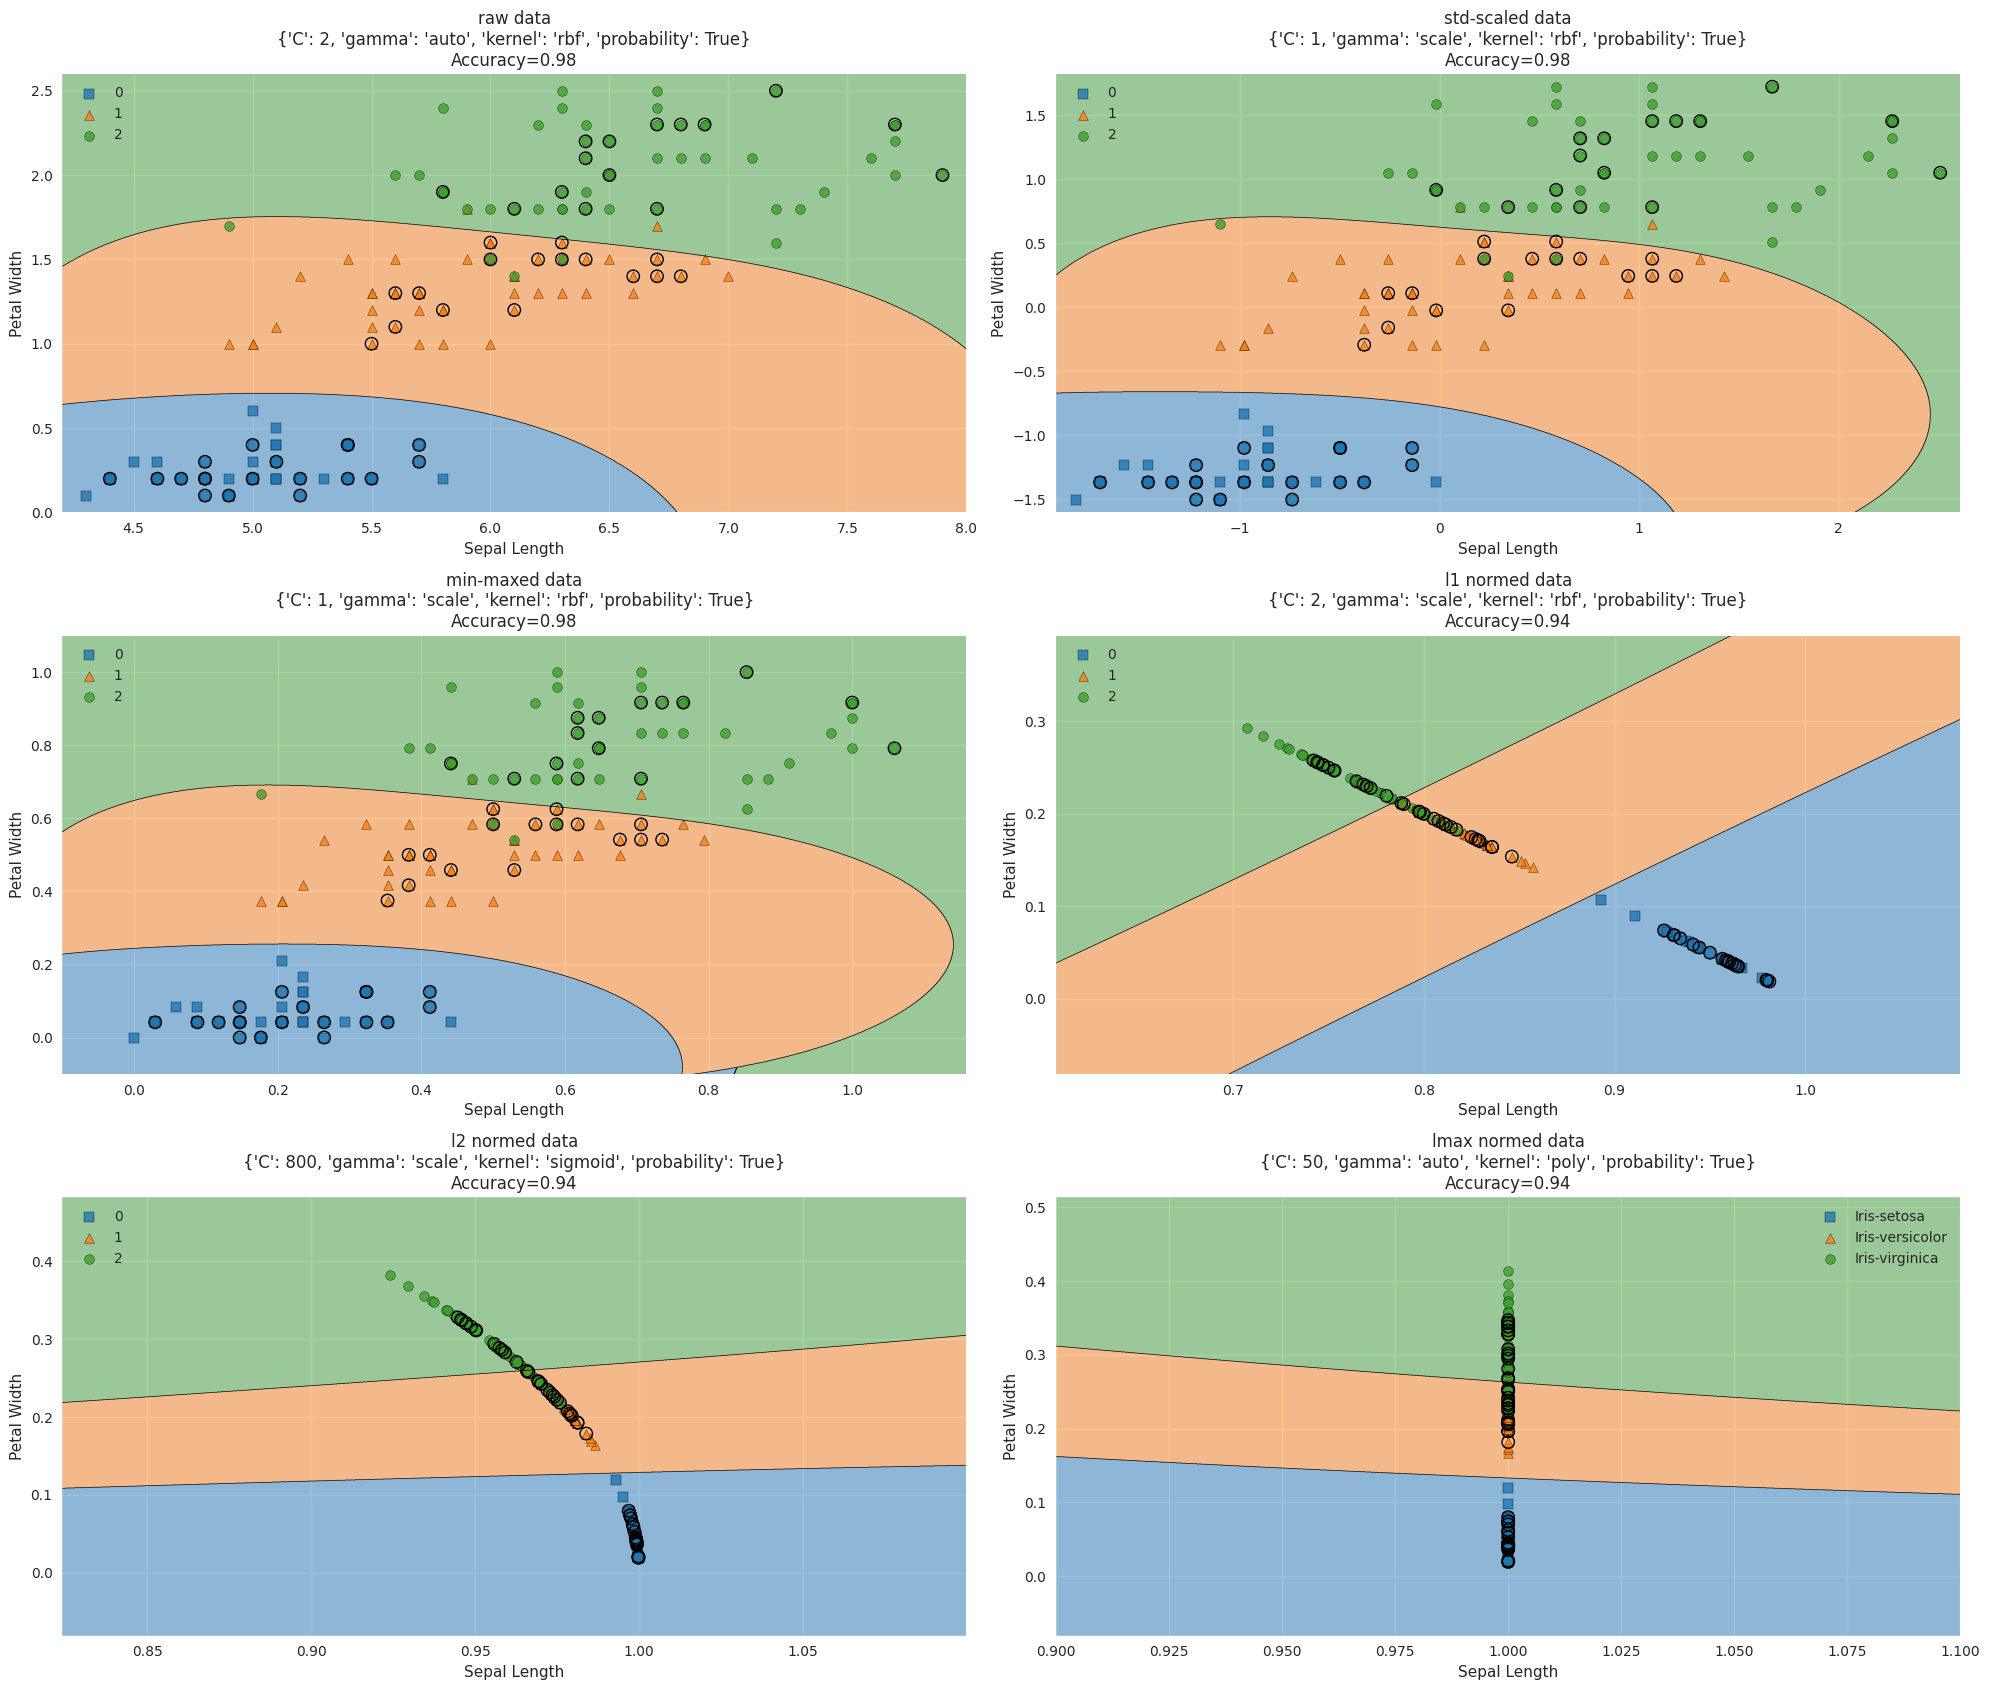

In [16]:
param_grid = {
    "C": [
        *range(1, 10, 1),
        *range(10, 100, 10),
        *range(100, 1000, 100),
    ],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "probability": [True, False],
}

# ParamGrid Length
print("ParamGrid length: {}".format(len(list(ParameterGrid(param_grid)))))

_, axes = plt.subplots(3, 2, figsize=(20, 17))

# For every preprocess modality
for i, (name, preprocessor) in enumerate(
    [
        ("raw", FunctionTransformer(lambda x: x, validate=False)), # does nothing to the data
        ("std-scaled", preprocessing.StandardScaler()),
        ("min-maxed", preprocessing.MinMaxScaler()),
        ("l1 normed", preprocessing.Normalizer(norm="l1")),
        ("l2 normed", preprocessing.Normalizer(norm="l2")),
        ("lmax normed", preprocessing.Normalizer(norm="max")),
    ]
):
    gs = Pipeline(
        [
            (name, preprocessor),
            (
                "search",
                GridSearchCV(
                    svm.SVC(random_state=random_state),
                    param_grid=param_grid,
                    n_jobs=-1,
                    cv=5,
                    refit=True,
                ),
            ),
        ]
    )

    # Fit
    gs.fit(X_train.values, y_train)

    # In this case the plot is a bit different: I manually composed the pipeline, inserting the preprocessed data as "X" and "X_highlight", and the estimator as "clf"
    plot_decision_regions(
        preprocessor.fit(X_train.values).transform(df_X.values),
        df_Y,
        clf=gs[1],
        legend=2,
        X_highlight=preprocessor.fit(X_train.values).transform(X_test.values),
        n_jobs=-1,
        zoom_factor=10,
        ax=axes[i // 2, i % 2],
    )
    axes[i // 2, i % 2].set_xlabel(df_X.columns[0])
    axes[i // 2, i % 2].set_ylabel(df_X.columns[1])
    plt.legend(encoder.classes_)
    axes[i // 2, i % 2].set_title(
        "{} data\n{}\nAccuracy={}".format(
            gs.steps[0][0],
            gs.steps[1][1].best_params_,
            gs.score(X_test.values, y_test),
        )
    )
plt.tight_layout()
plt.show()